## Summary overview | ARIMA (Autoregressive Integrated Moving Average)

#### Rolling ARIMA forecast (animated)

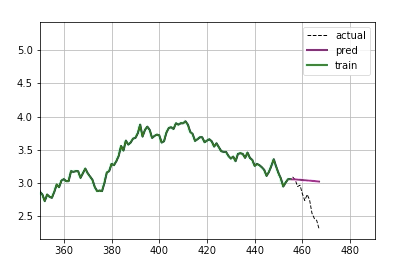

In [1]:
from IPython.display import Image
Image(filename='images/arima_snake.gif.png')

exploring the utility of an autoregressive integrated moving average model

#### ARIMA model

In [2]:
# general import environment
print('versions')
print ('------------')
import pandas as pd
print('pandas: ', pd.__version__)
pd.set_option('display.max_columns', None)

import numpy as np
print('numpy: ', np.__version__)

import time as time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
print('mpl: ', mpl.__version__)
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore") # ignore warnings

versions
------------
pandas:  0.20.3
numpy:  1.13.3
mpl:  2.0.2


### load cached data

In [3]:
#### load data
temporal_group = 'weekly'
df = pd.read_csv('data/historical_data_{0}.csv'.format(temporal_group))

In [4]:
# force convert string dates to dt objects
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
# identify single columns to target
target_column = 'DGS30'

In [6]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(timeseries,rolling_window=3):
    #calcualte rolling stats (mean/std deviation)
    rolmean = pd.Series(timeseries).rolling(window=rolling_window).mean().dropna()
    rolstd = pd.Series(timeseries).rolling(window=rolling_window).std().dropna()

    #plot rolling stats:
    orig = plt.plot(timeseries, color='green',label='data')
    mean = plt.plot(rolmean.values, color='purple', label='rolling_mean')
    std = plt.plot(rolstd.values, color='#295673', label = 'rolling_std',alpha=0.7)
    plt.legend(loc='best')
    plt.title('stationarity check | rolling stats')
    plt.show(block=False)
    
    print('dickey-fuller test:')
    print('=-=--==--=-=-=-==-=')
    dickey_fuller_results = adfuller(timeseries, autolag='AIC')  #returns tuple
    dfoutput = pd.Series(dickey_fuller_results[0:4], index=['test_stat','p_val','lag_num','n_obs'])  #[0:4] excludes 1,5,10% critical vals
    for key,value in dickey_fuller_results[4].items():
        dfoutput['crit vals ({0})'.format(key)] = value
    print(dfoutput)

In [7]:
timeseries = df[target_column].values

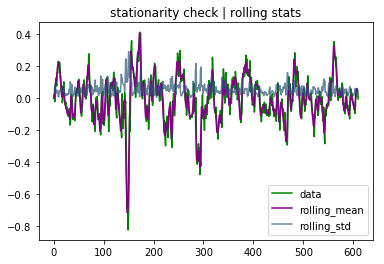

dickey-fuller test:
=-=--==--=-=-=-==-=
test_stat         -7.456430e+00
p_val              5.496858e-11
lag_num            1.000000e+00
n_obs              6.090000e+02
crit vals (1%)    -3.441133e+00
crit vals (5%)    -2.866298e+00
crit vals (10%)   -2.569304e+00
dtype: float64


In [8]:
# core timeseries is not stationary, can manually calculate (difference) to accommodate,
#or pass param to ARIMA model to address:
# -------------------
ewma_series = pd.ewma(timeseries, halflife=3)
diff_ewma = timeseries - ewma_series
stationarity_check(diff_ewma)

### train ARIMA model

In [9]:
# load ARIMA model
from statsmodels.tsa.arima_model import ARIMA

In [10]:
# isolate relevant data
arma_df = pd.DataFrame()
arma_df[target_column] = df[target_column]
print(len(arma_df))

611


In [11]:
# rename column
base_col = 't'
arma_df.rename(columns={target_column: base_col}, inplace=True)

In [12]:
# partition data into train/test sets
train_cut_pct = 0.90
cut_period = len(arma_df) - int(len(arma_df)*train_cut_pct)
print(cut_period)

62


In [13]:
X = arma_df.values
train, test = X[1:len(X)-cut_period], X[len(X)-cut_period:]
print(len(X))
print(len(train))
print(len(test))

611
548
62


In [14]:
# set model params, fit to training data
p_param=3 #auto-regressive order
d_param=1 #set to 1+ for non-stationary data, 0 otherwise
q_param=1 #moving avg order | 0 to exclude moving avg coeff.

model = ARIMA(train, order=(p_param,d_param,q_param))
model_fit = model.fit(disp=0) #disp = output suppression

In [15]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  547
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 497.237
Method:                       css-mle   S.D. of innovations              0.097
Date:                Tue, 17 Oct 2017   AIC                           -982.474
Time:                        15:07:02   BIC                           -956.647
Sample:                             1   HQIC                          -972.379
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.005     -0.818      0.414      -0.014       0.006
ar.L1.D.y      0.2921      0.685      0.426      0.670      -1.051       1.635
ar.L2.D.y      0.0107      0.107      0.100      0.9

#### evlauate predictions

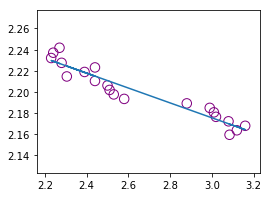

In [16]:
# prediction plot (test set) | longer range forecasts tend to have larger residuals
# a more effective strategy would be to retrain the model on a moving window and iteratively update short-term predictions
mpl.rc('figure', figsize=(4, 3))
test_num = 20
if test_num > cut_period:
    test_num = cut_period
    
xxx = test[:test_num].reshape(1,-1)[0]
yyy = model_fit.forecast(steps=test_num)[0]
plt.scatter(xxx, yyy, s=90, lw=1,facecolors='none', edgecolors='purple')
f1=np.polyfit(xxx,yyy,1)
plt.plot(xxx,np.polyval(f1,xxx))
plt.show()

In [17]:
# make predictions on test set
# denotes that predited change [d param > 0]
# ------------------------------------------
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [18]:
# #show prediction build:
# #----------------------
# for i in range(len(predictions)):
#     print('predicted={0}, actual={1}'.format(str(predictions[i]), str(test[i])),\
#           ' | resid: ',predictions[i]-test[i], ' ---> ', \
#           str(np.round(((predictions[i]-test[i])/(test[i])),5)),'%'   )
# print('--------')

In [19]:
# create dataframe to evaluate test set
preddf = pd.DataFrame({'test':test.reshape(1,-1)[0],'pred':predictions})
preddf['diff'] = (preddf['test'] - preddf['test'].shift(1))

In [20]:
# lag predicted diff
preddf['tmp'] = preddf['pred'].shift(-1).values

In [21]:
# compute predicted yield based on predicted diff
preddf['t+1_pred'] = preddf['tmp'] + preddf['test']
preddf['t+1_pred'] = preddf['t+1_pred'].shift(1)

In [22]:
# calculate residuals
preddf['resid'] = preddf['t+1_pred'] - preddf['test']

In [23]:
# drop NaNs (result of shifting)
preddf.dropna(inplace=True)

In [24]:
preddf.sample(2)

,pred,test,diff,tmp,t+1_pred,resid
51,-0.00426,2.82,-0.03,-0.00426,2.84574,0.02574
16,-0.00426,3.08,0.06,-0.00426,3.01574,-0.06426


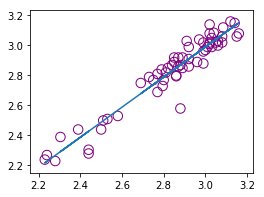

In [25]:
# scatter plot of predicted vs actual
xxx = preddf['test'].values
yyy = preddf['t+1_pred'].values
plt.scatter(xxx, yyy, s=90, lw=1,facecolors='none', edgecolors='purple')
f1=np.polyfit(xxx,yyy,1)
plt.plot(xxx,np.polyval(f1,xxx))
plt.show()

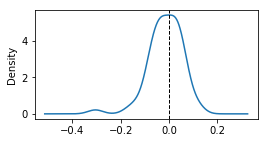

In [26]:
# quick sanity check that residuals ~normally dist
mpl.rc('figure', figsize=(4, 2))
preddf['resid'].plot(kind='kde')
plt.axvline(x=0,lw=1,linestyle='--',color='k')
plt.show()

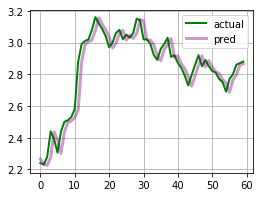

In [27]:
# plot predictions vs expected
mpl.rc('figure', figsize=(4, 3))
plt.plot(preddf['test'].values,color='green',lw=2)
plt.plot(preddf['t+1_pred'].values, color='purple',lw=3,alpha=0.4)
plt.grid(True)
plt.legend(['actual','pred'], loc='best')
plt.show()

### Rolling ARIMA forecasts

In [28]:
# partition data into train/test sets
train_cut_pct = 0.65
cut_period = len(arma_df) - int(len(arma_df)*train_cut_pct)
print(cut_period)

214


In [29]:
X = arma_df.values
train, test = X[1:len(X)-cut_period], X[len(X)-cut_period:]
print(len(X))
print(len(train))
print(len(test))

611
396
214


In [30]:
# iterate over test set, retrain model, cache results in list format, adjust training set, repeat....
forecast_steps = 12

import warnings
warnings.filterwarnings("ignore") # ignore warnings (suppress any maximum likelihood optimization converge failures)
alist, blist, clist, dlist, elist = ([] for i in range(5))
expanding_training_data = list(train.reshape(1,-1)[0])

p_param=4
d_param=1
q_param=1

for iter_x in np.arange(len(test)):
    tmp_model = ARIMA(expanding_training_data, order=(p_param,d_param,q_param))
    model_fit = tmp_model.fit(disp=0)
    # output = model_fit.forecast()
    output = model_fit.forecast(steps=forecast_steps)
    yhat = output[0][0] #prediction [point estimate]
    step_forcast = output[0]
    actual = test[iter_x][0]
    
    # cache iterable values
    alist.append(yhat)
    blist.append(output[1][0]) #stderr
    clist.append(output[2][0]) #conf_int
    dlist.append(actual)
    elist.append(step_forcast)
    expanding_training_data.append(actual)

In [31]:
# construct df from cached values
eval_df = pd.DataFrame({'pred':alist,'std_err':blist,'conf_int':clist,'actual':dlist,\
                        'forecast_steps_{0}'.format(forecast_steps):elist})
eval_df['resid'] = eval_df['pred'] - eval_df['actual']

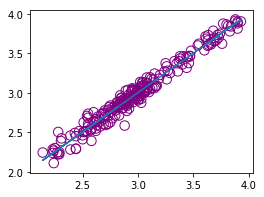

In [32]:
# scatter plot of predicted vs actual
xxx = eval_df['actual'].values
yyy = eval_df['pred'].values
plt.scatter(xxx, yyy, s=90, lw=1,facecolors='none', edgecolors='purple')
f1=np.polyfit(xxx,yyy,1)
plt.plot(xxx,np.polyval(f1,xxx))
plt.show()

## Model summary

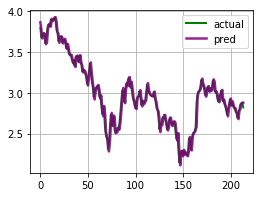

In [33]:
# plot predictions vs expected
plt.plot(eval_df['actual'].values,color='green',lw=2)
plt.plot(eval_df['pred'].values, color='purple',lw=2.5,alpha=0.85)
plt.grid(True)
plt.legend(['actual','pred'], loc='best')
plt.show()

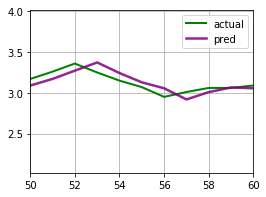

In [34]:
# Zooming in for better visual asssessment of residuals
# plot predictions vs expected
plt.plot(eval_df['actual'].values,color='green',lw=2)
plt.plot(eval_df['pred'].values, color='purple',lw=2.5,alpha=0.85)
plt.grid(True)
plt.legend(['actual','pred'], loc='best')
plt.xlim(50,60)
plt.show()

In [35]:
# MSE calc:
ljust_parma=14
print('MSE')
print('------------')
print('manual calc:'.ljust(ljust_parma),  str(np.sum((eval_df['resid'])**2) / len(eval_df))  )
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(eval_df['actual'].values, eval_df['pred'].values)  
print('sklearn:'.ljust(ljust_parma),  str(mse)  )

MSE
------------
manual calc:   0.00548535645314
sklearn:       0.00548535645314


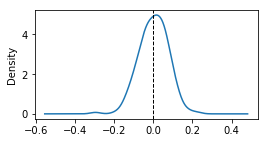

In [36]:
# quick sanity check that residuals normally dist
mpl.rc('figure', figsize=(4, 2))
eval_df['resid'].plot(kind='kde')
plt.axvline(x=0,lw=1,linestyle='--',color='k')
plt.show()

In [37]:
# calculate period over period diff
eval_df['diff'] = (eval_df['actual'] - eval_df['actual'].shift(1))
eval_df.dropna(inplace=True)

In [38]:
eval_df.head(5)

,actual,conf_int,forecast_steps_12,pred,std_err,resid,diff
1,3.68,"[3.58185126487, 3.99082535616]","[3.78633831052, 3.78880019458, 3.78267505893, ...",3.786338,0.104332,0.106338,-0.12
2,3.71,"[3.46362811351, 3.87261232259]","[3.66812021805, 3.65279164165, 3.64875662859, ...",3.668120,0.104335,-0.041880,0.03
3,3.73,"[3.496204614, 3.90475592071]","[3.70048026736, 3.70002440098, 3.69224457369, ...",3.700480,0.104224,-0.029520,0.02
4,3.72,"[3.52958768082, 3.9376675624]","[3.73362762161, 3.72842381055, 3.730841254, 3....",3.733628,0.104104,0.013628,-0.01
5,3.61,"[3.50909320778, 3.91667137788]","[3.71288229283, 3.71412672634, 3.71027103025, ...",3.712882,0.103976,0.102882,-0.11


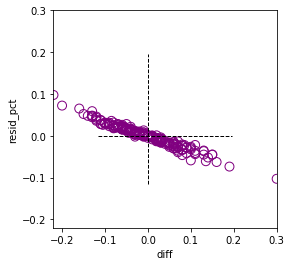

In [39]:
# residual plot:
mpl.rc('figure', figsize=(4, 4))

# create percentage diff (residual / period diff)
eval_df['resid_pct'] = eval_df['resid'] / eval_df['actual']

# scatter plot diff vs. pct miss
x_input = 'diff'
y_input = 'resid_pct'
xxx = eval_df[x_input].values[1:]
yyy = eval_df[y_input].values[1:]
plt.scatter(xxx, yyy, s=80, facecolors='none', edgecolors='purple')
plt.xlabel('{0}'.format(x_input))
plt.ylabel('{0}'.format(y_input))
plt.axvline(x=0,ymin=0.2,ymax=0.8,lw=1,linestyle='--',color='k')
plt.axhline(y=0,xmin=0.2,xmax=0.8,lw=1,linestyle='--',color='k')

plt.xlim(min(eval_df[x_input].min(),eval_df[y_input].min()),max(eval_df[x_input].max(),eval_df[y_input].max()))
plt.ylim(min(eval_df[x_input].min(),eval_df[y_input].min()),max(eval_df[x_input].max(),eval_df[y_input].max()))
plt.show()

#### evaluate rolling steps

In [40]:
# create separate df object for analysis
stepdf = pd.DataFrame()
stepdf['actual'] = eval_df['actual']
stepdf['forecast_steps_{0}'.format(forecast_steps)] = eval_df['forecast_steps_{0}'.format(forecast_steps)]

In [41]:
# rename column
base_col = 't'
stepdf.rename(columns={'actual': base_col}, inplace=True)

In [42]:
# iterate through forecast periods and calc t+n values with shifts
for iter_x in (np.arange(forecast_steps)+1):
    stepdf['t+{0}'.format(iter_x)] = stepdf[base_col].shift(-iter_x)

In [43]:
# extract all t+n forecasts from list-structured column
def forecast_extract(s,iter_n):
    return s[iter_n]

for iter_x in (np.arange(forecast_steps)+1):
    stepdf['pred+{0}'.format(iter_x)] = stepdf['forecast_steps_{0}'.format(forecast_steps)]\
    .apply(forecast_extract,iter_n=(iter_x-1))

In [44]:
# drop superfluous column
stepdf.drop('forecast_steps_{0}'.format(forecast_steps), axis=1, inplace=True)

In [45]:
# iterate over n forecast steps and calculate residuals
for iter_x in (np.arange(forecast_steps)+1):
    stepdf['resid_{0}'.format(iter_x)] = stepdf['pred+{0}'.format(iter_x)] - stepdf['t+{0}'.format(iter_x)]

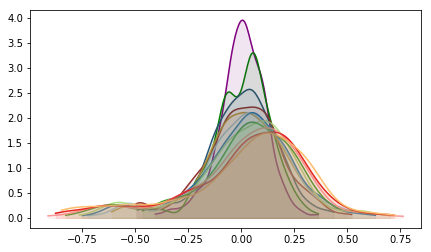

In [46]:
# expectedly, residuals are more tightly bound over shorter prediction horizons

mpl.rc('figure', figsize=(7, 4))
color_list = ['purple','green','#295673','#93322D','#C4A13D','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
from matplotlib import cm
colors = np.linspace(0,1,forecast_steps)

from scipy.stats import gaussian_kde

for iter_x in (np.arange(forecast_steps)+1):
    x_input = 'resid_{0}'.format(iter_x)
    data = stepdf[x_input].dropna()
    density = gaussian_kde(data)
    xs = np.linspace(data.min(),data.max(),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs),color=color_list[(iter_x-1)])
    plt.fill_between(xs,density(xs),alpha=0.1,zorder=5, antialiased=True, color=color_list[(iter_x-1)])
plt.show;

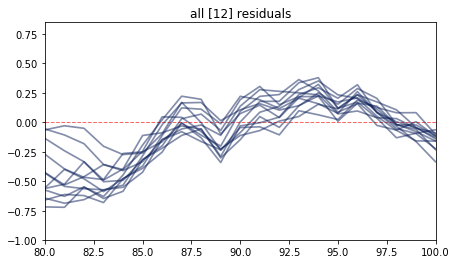

In [47]:
from matplotlib import cm
colors = np.linspace(0,1,forecast_steps)
plt.axhline(y=0,lw=1,linestyle='--',color='r',alpha=0.6)
for iter_x in (np.arange(forecast_steps)+1):
    stepdf['resid_{0}'.format(iter_x)].plot(lw=1.7,c=colors,cmap=cm.YlGnBu_r,alpha=0.5)
plt.xlim(80,100)
plt.title('all [{0}] residuals'.format(forecast_steps))
plt.show;

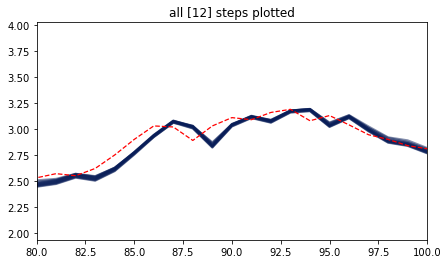

In [48]:
# ARIMA forecasts have a pretty tight range [max-min]
from matplotlib import cm
colors = np.linspace(0,1,forecast_steps)

for iter_x in (np.arange(forecast_steps)+1):
    stepdf['pred+{0}'.format(iter_x)].plot(lw=2,c=colors,cmap=cm.YlGnBu_r,alpha=0.5)
stepdf[base_col].plot(c='red',linestyle='--',lw=1.25,alpha=1.0)
plt.xlim(80,100)
plt.title('all [{0}] steps plotted'.format(forecast_steps))
plt.show;

#### ARIMA == meh